## In this notebook, we will compute the power spectrum of the curvature perturbation $\mathcal{R}$ for generalized single field models that exhibit slow-roll violation where the action of the latter satisfies:

### $$ {\rm d} \bar{\tau} = c_s {\rm d \tau} \quad \Longrightarrow \quad S^{(2)}_{\mathcal{R}} = \frac{1}{2}\int {\rm d} \bar{\tau}\, {\rm d}^3 x\, z^2(\bar{\tau})\, \bigg[\mathcal{R}'^2 - (\vec{\nabla} \mathcal{R})^2\bigg]. $$

## In this framework, the pump field can be described as 

### $$ z^2(\bar \tau) \, = \,\frac{2\,a^2(\bar \tau)\, M^2(\bar \tau)\,\epsilon (\bar \tau)}{c_s(\bar \tau)}. $$

## The Mukhanov-Sasaki (MS) equation $v = z \mathcal{R}$ is given by

### $$ v_k''(\tilde{\tau}) + \left(k^2 - \frac{z''}{z}\right)v_k(\tilde{\tau}) = 0,$$ 

## where 

### $$ \frac{z''}{z} = \left(\frac{aH}{c_s}\right)^2 \left[(1 - \epsilon - s)\left(1 + \frac{\eta - s +\mu_1}{2}\right) + \left(1 + \frac{\eta - s +\mu_1}{2}\right)^2 + \frac{1}{2}\left(\frac{{\rm d}\eta}{{\rm d}N}+ \frac{{\rm d}s}{{\rm d}N} + \frac{{\rm d}\mu_1}{{\rm d}N}\right) \right]$$

## Deep inside the horizon $k^2 \gg z''/z$,  mode functions of MS variable is subject to Bunch-Davies vacuum conditions:

### $$ v_k(\tilde{\tau})\, \bigg|_{\rm in} = \frac{e^{-ik\tilde{\tau}}}{\sqrt{2k}}, \quad\quad\quad v_k'(\tilde{\tau})\, \bigg|_{\rm in} = -ik v_k(\tilde{\tau})\, \bigg|_{\rm in}.$$

## In terms of the MS variable, we can write the late time power spectrum of the curvature perturbation as 

### $$ \mathcal{R}_k = \frac{v_k}{z} \quad \rightarrow \quad \mathcal{P}_{\mathcal{R}} = \frac{k^3}{2\pi^2} \bigg|\frac{v_k}{z}\bigg|^2.$$

##  To determine the behavior of each $k$ mode we need to: 

## 1. Charecterize the background evolution in terms of 
### $$\epsilon = -\frac{{\rm d}\ln H}{{\rm d}N},\,\,\eta \equiv \frac{{\rm d}\ln \epsilon}{{\rm d}N},\,\,c_s,\,\,s \equiv \frac{{\rm d}\ln {c_s}}{{\rm d}N},\,\,\mu_0 = M^2,\,\,\mu_1 \equiv \frac{{{\rm d} \ln \mu_0}}{{\rm d} N }$$
### $$\epsilon_3 = \eta^{-1}\frac{{\rm d}\eta}{{\rm d}N},\,\,\quad s_2 = s^{-1}\frac{{\rm d}s}{{\rm d}N},\,\,\quad \mu_2 = {\mu_{1}}^{-1}\frac{{\rm d}\mu_1}{{\rm d}N}$$
##  2. Given a particular background solution as described above, solve MS equation for many k modes by initializing them in the BD vacuum
***

In [1]:
# Load Libraries and prelimenaries for inline plotting 

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as Nint
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq

In [2]:
# Defining the slow-roll hierarchy and model parameters 
# as defined above following the parameter/variable choices and definitions provided in arXiv: 1811.03065 

# First line 
def eps(n):
    n1e = -2; n2e = -4; nse = 36.; se = 2.;
    return 10**((n1e-n2e)*np.tanh((n-nse)/se)**2 + n2e)

def cs(n):
    n1cs = 0; n2cs = -2; nscs = 35.5; scs = 2.5;
    return 10**((n1cs-n2cs)*np.tanh((n-nscs)/scs)**2 + n2cs)

def Msq(n):
    n1m = 0; n2m = -3; nsm = 34.8; sm = 4;
    return 10**((n1m-n2m)*np.tanh((n-nsm)/sm)**2 + n2m)

def eta(n):
    return 4.60517 * (1/np.cosh(0.5*(-36.+n)))**2 * np.tanh(0.5 * (-36.+n))

def s(n):
    return 3.68414 * (1/np.cosh(0.4*(-35.5+n)))**2 * np.tanh(0.4 * (-35.5+n))

def mu1(n):
    return 1.5 * np.log(10) * (1/np.cosh(0.25 * (-34.8+n)))**2 * np.tanh(0.25 * (-34.8+n))

# Second line 

def e3(n):
    return 0.217147 * np.cosh(0.5 * (-36. + n))**2 * (1/np.tanh(0.5 * (-36. + n))) * (2.30259 * (1/np.cosh(0.5 * (-36. + n)))**4 - 
  4.60517 * (1/np.cosh(0.5 * (-36. + n)))**2 * np.tanh(0.5 * (-36. + n))**2)

def s2(n):
    return 0.271434 * np.cosh(0.4 *(-35.5+n))**2 * (1/np.tanh(0.4 * (-35.5 + n)))* (1.47366 * (1/np.cosh(0.4 * (-35.5 + n)))**4 - 
  2.94731 * (1/np.cosh(0.4 * (-35.5 + n)))**2 * np.tanh(0.4 * (-35.5 + n))**2)

def mu2(n):
    return (2 * np.cosh((-34.8+n)/4)**2 * (1/np.tanh((-34.8 + n)/4)) * (3 * (np.log(10)/8) * (1/np.cosh((-34.8 + n)/4))**4 - 
  3 * (np.log(10)/4) * (1/np.cosh((-34.8 + n)/4))**2 * np.tanh((-34.8 + n)/4)**2))/(3 * np.log(10))

###### Defining Hubble rate integrating epsilon where we normalize it as Hubble = H_{end} H(n) 

efl = np.linspace(0, 60, 1000) 

Hubble = []
for i in efl:
    Hubble.append(np.exp(- Nint.quad(lambda t: eps(t), 60, i)[0]))

H = interp1d(efl,Hubble, kind='cubic', bounds_error=False) # Define an interpolation function of H

# Generate some interpolating functions using the functions we defined above,
# to check if the code gets faster or not

epsdat = []
for i in efl:
    epsdat.append(eps(i))

inteps = interp1d(efl, epsdat, kind='cubic', bounds_error=False)   

csdat = []
for i in efl:
    csdat.append(cs(i))

intcs = interp1d(efl,csdat, kind='cubic', bounds_error=False)   

Msqdat = []
for i in efl:
    Msqdat.append(Msq(i))

intMsq = interp1d(efl,Msqdat, kind='cubic', bounds_error=False)   

etadat = []
for i in efl:
    etadat.append(eta(i))

inteta = interp1d(efl,etadat, kind='cubic', bounds_error=False)   

sdat = []
for i in efl:
    sdat.append(s(i))

ints = interp1d(efl,sdat, kind='cubic', bounds_error=False)   

mu1dat = []
for i in efl:
    mu1dat.append(mu1(i))

intmu1 = interp1d(efl,mu1dat, kind='cubic', bounds_error=False)   

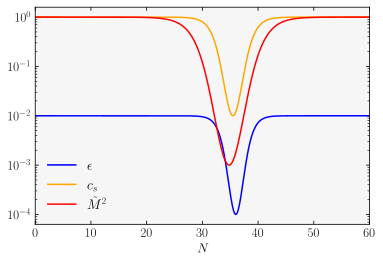

In [3]:
################################### Plotting eps, cs, M^2 ########################################################

plt.rcParams['text.usetex'] = True

plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')

plt.yscale('log')

plt.axvspan(0,60, alpha = 0.07, color = 'gray')

plt.xlabel(r'$ N $',fontsize=13)
plt.xlim(0,60)

plt.plot(efl,eps(efl),'b', label = r'$\epsilon$')
plt.plot(efl,cs(efl), color = 'orange', label = r'$c_s$')
plt.plot(efl,Msq(efl),'r', label = r'$ \tilde{M}^2 $')

plt.legend(loc = 'best', fontsize = 14, frameon = False)
plt.savefig('gback.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)

In [ ]:
######################################## Plotting Hubble rate ####################################################

# plt.rcParams['text.usetex'] = True
# plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
# plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')
# plt.yscale('log')
# plt.xlabel(r'$ N $',fontsize=13)
# plt.xlim(0,60)
# plt.ylabel(r' $\frac{H}{H_{\rm end}}$ ', fontsize = 20, rotation = 0,  labelpad = 30)
# plt.plot(efl, H(efl),'k')

In [6]:
############ Plotting the "damping term" that qualitatively determine the behavior of curvature perturbation #####

# def xi(n):
#    return 3 - eps(n) + eta(n) - 2 * s(n) + mu1(n)
# def intxi(n):
#    return 3 - inteps(n) + inteta(n) - 2 * ints(n) + intmu1(n)

# plt.rcParams['text.usetex'] = True
# plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
# plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')
# plt.xlabel(r'$ N $',fontsize=13)
# plt.xlim(0,60)
# plt.ylim(0,5)
#plt.ylabel(r' $\epsilon(N)$ ', fontsize=13, rotation = 0,  labelpad = 20)
# plt.plot(efl,xi(efl),'b', label = r'$\xi = 3 - \epsilon + \eta - 2 s + \mu_1 $')
# plt.plot(efl, intxi(efl)  ,'r:')
# plt.legend(loc = 3, fontsize = 12)

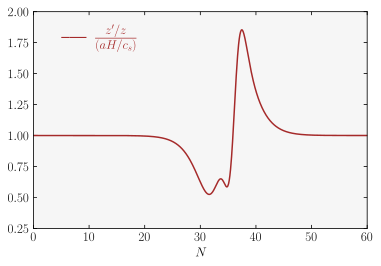

In [7]:
########################################### Define and plot z'/z ############################################
def zpoz(n):
    return 1 + 0.5 * (inteta(n) - ints(n) + intmu1(n))

plt.rcParams['text.usetex'] = True

plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')
plt.axvspan(0,60, alpha = 0.07, color = 'gray')
plt.text(5, 1.75, r'\raisebox{2pt}{--}\raisebox{2pt}{---}\,\,\,$ \frac{z^{\prime}/z}{(aH/c_s)}$', color = 'brown', fontsize=18)

plt.xlabel(r'$ N $',fontsize=13)
plt.xlim(0,60)
plt.ylim(0.25,2)


plt.plot(efl,zpoz(efl), color = 'brown')
#plt.legend(loc = 3, fontsize = 13, frameon = False)
#plt.savefig('gzpoz.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)

## Define a new variable through:
### $$v_k = \bar{v}_k \frac{e^{-ik\tilde{\tau}}}{\sqrt{2k}}$$

## EoM of the new variable satisfies:

### $$\bar{v}_k''(N) + \left((1-\epsilon -s)-2i \frac{c_s k}{aH}\right)\bar{v}_k'(N) - \frac{c_s^2 z''}{(aH)^2 z}\bar{v}_k(N) = 0, $$
##  where primes denote derivative with respect to:  
### $${\rm d N} = H\, {\rm d}t = (aH)\,{\rm d}\tau = \left(\frac{aH}{c_s}\right)\,{\rm d}\tilde{\tau},$$
## noting 
### $$\quad {\rm d} \tilde{\tau} = c_s {\rm d}\tau = \frac{c_s}{a} {\rm d} t .$$

## MS variable is subject to BD initial conditions:
### $$\bar{v}_k\, \big|_{\rm in} = 1 , \quad \bar{v}_k'\, \big|_{\rm in} = 0$$

### $$\frac{z''}{z} = \left(\frac{aH}{c_s}\right)^2 \left[(1 - \epsilon - s)\left(1 + \frac{\eta - s +\mu_1}{2}\right) + \left(1 + \frac{\eta - s +\mu_1}{2}\right)^2 + \frac{1}{2}\left(\frac{{\rm d}\eta}{{\rm d}N}+ \frac{{\rm d}s}{{\rm d}N} + \frac{{\rm d}\mu_1}{{\rm d}N}\right) \right]$$
## noting

### $$a = a_{\rm end} e^{N-60}, \quad\quad H = H_{\rm end} \exp\left[-{\int_{60}^N {\rm d}N\, \epsilon(N)}\right]$$



In [14]:
# We are going to solve MS for many different k values, so first we generate an array of wave-numbers defined
# with respect to k_{end} = a_{end} H_{end} namely the mode that exit the horizon right at the end of inflation

k_ini = (1.01/250) * 10**(-20); #Chosen on purpose to this value to make the resulting pheno interesting at LISA scales
k_fin = 4 * 10**(-9); # Note again these numbers indicate the ratio k/k_{end}

kk=[]   # Generate an empty list to fill below

for i in np.arange(1,351):
    kk.append(k_ini*(k_fin/k_ini)**((i-1)/(350-1)))
    
print(len(kk),kk[len(kk)-1])  

350 4e-09


In [15]:
######## To finely capture the behavior of PS after the peak, divide small scales into a more refined k space 

ks_ini = 4. * 10**(-9); 
ks_fin = 1. * 10**(-7); 

kks=[] # Generate an empty list an fill it iteratively by evaluating integral below

for i in np.arange(1,401):
    kks.append(ksini*(ksfin/ksini)**((i-1)/(400-1)))
    
print(len(kks),kks[len(kks)-1])

400 1e-07


## Finding the horizon crossing time through 
### $$k^2 = \frac{z''}{2z}\,\bigg|_{N_c}$$

## and initialize the modes at 
### $$ N_{\rm in} = N_{\rm hc} - 4$$

In [30]:
#################### Define z''/z, note that it is defined in units of (a_{end} H_{end})^2 #######################

def zppoz(n):
    return ((np.exp(n-60)* H(n) / intcs(n))**2) * ((1 - inteps(n) - ints(n))*(1 + 0.5 * (inteta(n) - ints(n) + intmu1(n))) + (1 + 0.5 * ( inteta(n) - ints(n) + intmu1(n) ))**2 + (0.5 * ((e3(n) * inteta(n)) - (s2(n) * ints(n)) + (mu2(n) * intmu1(n)))))

######################## Solve for e-fold number of horizon crossing for each k defined above  ##################
n_hc = []
for item in kk:
    n_hc.append(brentq(lambda n: item - (abs(zppoz(n))/2)**(0.5),5,50))
    
ns_hc = []
for item in kks:
    ns_hc.append(brentq(lambda n: item - (abs(zppoz(n))/2)**(0.5),30,45))
    
# to initilize all k modes, we choose to start the evaluation 4-folds before the horizon crossing
# to ensure that all the modes we evaluate are inside the horizon initially

n_in = [x - 4 for x in n_hc]

ns_in = [x - 4 for x in ns_hc]

## Solving the new MS equation for $\bar{v}_k$ as defined above for the largest scale we consider for the purpose of normalizing the power spectrum

In [23]:
# Define the system of equations satisfied by v_k(N), v_k'(N)
def eomv(t,v,k):
    
    vc = v[0]
    vcp = v[1]
    
    vdot = [[],[]]
    
    vdot[0] = vcp
    vdot[1] = - ((1 - inteps(t) - ints(t)) - (0 + 2.j) * intcs(t)* k/(np.exp(t-60) * H(t)))* vcp + ((1 - inteps(t) - ints(t))*(1 + 0.5 * (inteta(t) - ints(t) + intmu1(t))) + (1 + 0.5 * (inteta(t) - ints(t) + intmu1(t)))**2 + (0.5 * ((e3(t) * inteta(t)) - (s2(t) * ints(t)) + (mu2(t) * intmu1(t))))) * vc
    return vdot

vin = [1. + 0.j, 0 + 0.j] # Initial conditions to be passed to the diff eq. solver solve_ivp 

# solving only for the initial k, i.e kk[0]

sol = solve_ivp(lambda t,v: eomv(t,v,kk[0]),(n_in[0],60), vin, max_step = 0.1) 

# DOP853 method could be also used with max_step=0.1

In [24]:
# Generate an interpolation function of the solution for \bar{v}_k

vcs_sq = abs(sol.y[0])**2
n_s = sol.t

sol_vcs_sq = interp1d(n_s, vcs_sq) # Define the interpolation function using the list we just generated

## Enforce PS normalization at the pivot scale k_cmb = kk[0]: 
### $$\mathcal{P}_{\mathcal{R}}(N_{\rm end} , k_{\rm cmb}) = \frac{H_{\rm end}^2}{8\pi^2 \epsilon(N_{\rm end})M_{\rm pl}^2} \frac{c_s(N_{\rm end})}{\tilde{M}(N_{\rm end})^2}\left(\frac{k_{\rm cmb}}{k_{\rm end}}\right)^2 \,\, \bigg| \bar{v}_{k_{\rm cmb}}(N_{\rm end}) \bigg|^2 = 2.1 \times 10^{-9}$$
## to obtain a value for: 
### $$\frac{H_{\rm end}}{M_{\rm pl}}, \quad {\rm noting}\quad \tilde{M} = M / M_{\rm pl}$$

In [28]:
Hend = brentq(lambda x: (x/(8 * (np.pi**2) * eps(60))**(0.5))*((intcs(60)/intMsq(60))**0.5) *(kk[0]) * (vcs_sq[len(vcs_sq)-1])**0.5 - (2.1*10**(-9))**(0.5),0,1)
print(Hend)

2.5950845948838554e-05


In [200]:
###################################### Solve the new MS for all k's ###########################################

# First run this cell and then the following the populate the txt file for all the k modes we defined above

for i in range(0,len(kks)):
    
    solf1 = solve_ivp(lambda t,v: eomv(t,v,kks[i]),(ns_in[i],60), vin,  method = 'DOP853', max_step = 0.05)
    
    vc_sq1 = abs(solf1.y[0])**2 # A list of solutions at each e-fold (between n_in[i] and 60) 
                               # generated by the solve_ivp above
    
    powa = (Hend**2/(8*np.pi**2*eps(60))) * (intcs(60)/intMsq(60)) * (kks[i]**2) * (vc_sq[len(vc_sq)-1])
    
    psfile = open('powerspecs.txt','a')
    psfile.write(str(kks[i]) + ',' + ' ' + str(powa) + '\n')
    psfile.close()
    

In [ ]:
for i in range(0,len(kk)):
    
    solf2 = solve_ivp(lambda t,v: eomv(t,v,kk[i]),(n_in[i],60), vin,  method = 'DOP853', max_step = 0.05)
    
    vc_sq2 = abs(solf2.y[0])**2 # A list of solutions at each e-fold (between n_in[i] and 60) 
                               # generated by the solve_ivp above
    
    powa = (Hend**2/(8*np.pi**2*eps(60))) * (intcs(60)/intMsq(60)) * (kk[i]**2) * (vc_sq2[len(vc_sq2)-1])
    
    psfile = open('powerspecs.txt','a')
    psfile.write(str(kk[i]) + ',' + ' ' + str(powa) + '\n')
    psfile.close()
    

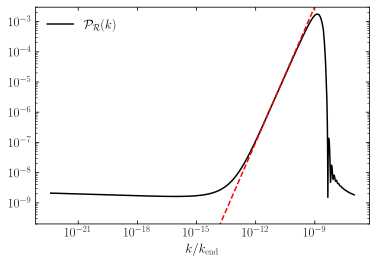

In [33]:
########## First plot the "raw" data generated: this will provide the power spectrum vs k/k_{end} ##############

fig = plt.figure()

powadata = np.loadtxt('powerspecs.txt', delimiter= ',')
kokend = powadata[:, 0] # k/k_{end} values
psR = powadata[:, 1]

# Prediction for the PS from the analytic formulas developed in the Review (optional)
#powaandata = np.loadtxt('Psanalyticf.txt')
#kokendan = powaandata[:,0]
#psRan = powaandata[:,1]

plt.rcParams['text.usetex'] = True

plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')

plt.xscale('log')
plt.yscale('log')

plt.ylim(2 * 10**(-10), 3 * 10**(-3))

plt.xlabel(r'$ k/k_{\rm end}$',fontsize=13)

plt.plot(kokend, psR,'k',label = r' $\mathcal{P}_{\mathcal{R}}(k)$ ')

plt.plot(kokend, 10**11 * kokend**(1.5),color = 'red', linestyle = 'dashed')
#plt.scatter(kokendan,psRan, marker = 'o', alpha = 0.4, color = 'blue', s = 15, label = r' $\mathcal{P}_{\mathcal{R}}(k)$ via eq. (3.17) ')
plt.legend(loc='best',fontsize = 13, frameon = False)

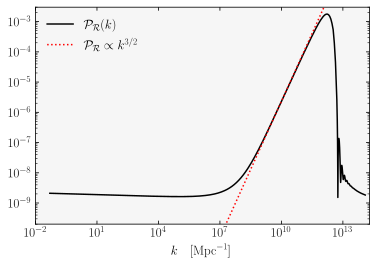

In [34]:
######################## Convert our normalization to actual k space in Mpc^{-1}  ################################

kcmb = 0.05 # in inverse Mpc
kend = kcmb/kokend[0] # we set k_{cmb}/k_{end} = kokend[0] where PS is normalized to 2.1 times 10^{-9}

klistMpc = [kend * x for x in kokend]

#klistanMpc = [kend * x for x in kokendan]


# And plot again 
plt.rcParams['text.usetex'] = True
plt.minorticks_on()
plt.rcParams['figure.figsize']=(6,4)
plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')

plt.axvspan(10**(-3),10**(15), alpha = 0.07, color = 'gray')

# To plot a reference line for the slope of the power spectrum
x = np.linspace(10**4,10**15,300)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01,2*10**14)
plt.ylim(2 * 10**(-10), 3 * 10**(-3))

plt.xlabel(r'$ k \quad [{\rm Mpc}^{-1}]$',fontsize=13)

plt.plot(klistMpc, psR,'k',label = r' $\mathcal{P}_{\mathcal{R}}(k)$ ')
plt.plot(x, 2.3*10**(-21)* (x**(3/2)),color = 'red', linestyle = 'dotted', label = r'$\mathcal{P}_{\mathcal{R}} \propto k^{3/2}$')
#plt.scatter(klistanMpc,psRan, marker = 'o', alpha = 0.5, color = 'blue', s = 15, label = r' $\mathcal{P}_{\mathcal{R}}(k)$ \textrm{via eq. (3.30)} ')
plt.legend(loc='best',fontsize = 13, frameon = False)
#plt.savefig('gps1.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)

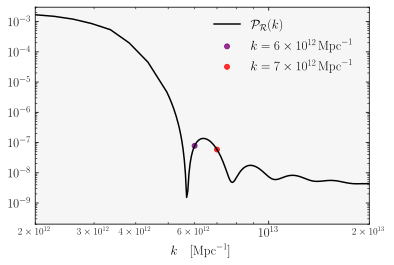

In [35]:
############################## Zoomed in plot for scales following the peak ######################################
intps = interp1d(klistMpc, psR, kind='cubic')
intpsosc1 = intps(6*10**12)
intpsosc2 = intps(7*10**12)
# And plot again 
plt.rcParams['text.usetex'] = True
plt.minorticks_on()

plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')

plt.xscale('log')
plt.yscale('log')
plt.axvspan(10**(-3),10**(15), alpha = 0.07, color = 'gray')

plt.xlim(2 *10**(12),2*10**13)
plt.ylim(2 * 10**(-10), 3 * 10**(-3))

plt.xlabel(r'$ k \quad [{\rm Mpc}^{-1}]$',fontsize=13)

plt.plot(klistMpc, psR,'k',label = r' $\mathcal{P}_{\mathcal{R}}(k)$ ')
plt.scatter(6*10**12,intpsosc1, marker = 'o', alpha = 0.8, color = 'purple', s = 25, label = r' $k = 6 \times 10^{12}\,{\rm Mpc}^{-1}$ ')
plt.scatter(7*10**12,intpsosc2, marker = 'o', alpha = 0.8, color = 'red', s = 25, label = r' $k = 7 \times 10^{12}\,{\rm Mpc}^{-1}$ ')
plt.legend(loc='best',fontsize = 13, frameon = False)
#plt.savefig('gps2.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)

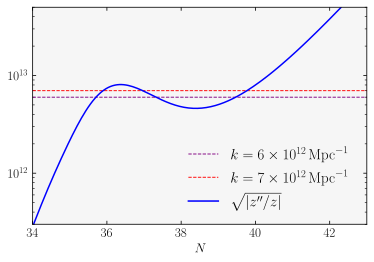

In [36]:
######### k^2 vs z''/z to illustrate the multiple horizon crossing of modes labeled by purple and red dot ########
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize']=(6,4)
plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')
plt.xlabel(r'$ N $',fontsize=13)

plt.yscale('log')
plt.xlim(34,43)
plt.axvspan(34,43, alpha = 0.07, color = 'gray')
plt.ylim(3 * 10**(11),5* 10**(13))

ks = brentq(lambda k:  k - kend * (abs(zppoz(36.6))/2)**(0.5),10**12,10**13) # The mode that exits at N = 35.7


plt.axhline(6*10**12, color = 'purple', linestyle = '--', lw = 0.9, label = r' $k = 6 \times 10^{12}\,{\rm Mpc}^{-1}$ ')
plt.axhline(7*10**12, color = 'red', linestyle = '--', lw = 0.9, label = r' $k = 7 \times 10^{12}\,{\rm Mpc}^{-1}$ ')

#plt.ylabel(r' $\frac{z^{\prime\prime}/z}{(aH/c_s)^2}$ ', fontsize=16, rotation = 0,  labelpad = 35)
plt.plot(efl, kend * (abs(zppoz(efl)))**0.5 ,'b', label = r' $\sqrt{\big|{z^{\prime\prime}}/{z}\big|}$ ')
plt.legend(loc = 4, fontsize = 15, frameon = False)
#plt.savefig('gzpozvsk.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)

In [40]:
########### Convert back these modes to k/k_{end} to solve for the mode evolution for these specific modes #######

kdhc1 = (6 * 10 ** 12) / kend
kdhc2 = (7 * 10 ** 12) / kend 
kdhc = [kdhc1, kdhc2] #Modes that undergo multiple horizon crossing 

ndhcin = [] # Set the initial time for mode evolution as the horizon crossing - 4 e-folds as usual

for item in kdhc:
    ndhcin.append(brentq(lambda n: item - (abs(zppoz(n))/2)**(0.5),5,50)-4)

In [41]:
############### Solving for the new MS variable (\bar{v}_k) for the two modes above ####################

soldhc1 = solve_ivp(lambda t,v: eomv(t,v,kdhc1),(33,60), vin, method = 'DOP853', max_step = 0.01) # DOP853 method could be also used with max_step=0.1
soldhc2 = solve_ivp(lambda t,v: eomv(t,v,kdhc2),(33,60), vin, method = 'DOP853', max_step = 0.01) # DOP853 method could be also used with max_step=0.1

In [44]:
############## Generate an interpolation function of the solution for \bar{v}_k ##########################

vcsdhc1 = abs(soldhc1.y[0])
nsdhc1 = soldhc1.t

vcsdhc2 = abs(soldhc2.y[0])
nsdhc2 = soldhc2.t


solvdhc1 = interp1d(nsdhc1, vcsdhc1) # Define the interpolation function using the list we just generated
solvdhc2 = interp1d(nsdhc2, vcsdhc2) 

In [45]:
############################ Define the pump field so we can plot v/z below ###############################

def z(n):
    return (2 * np.exp(2*(n-60)) * intMsq(n) * inteps(n) / intcs(n))**(0.5)

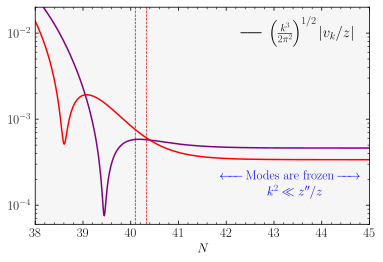

In [46]:
########################################## Plotting v_k / z ################################################

####### Recall that we need to take into account some conversion factors from \bar{v}_k to v_k #######

plt.rcParams['text.usetex'] = True
plt.minorticks_on()

plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')
plt.rcParams['figure.figsize']=(6,4)

plt.yscale('log')

plt.text(42.3, 9 * 10**(-3), r'\raisebox{2pt}{--}\raisebox{2pt}{---}\,\,\,$ \left(\frac{k^3}{2\pi^2}\right)^{1/2}\Bigg|{v_k}/{z}\Bigg|$', color = 'black', fontsize=15)
plt.text(42.85, 1.3* 10**(-4), r'$k^2 \ll z^{\prime\prime}/z$', color = 'blue', fontsize=13)
plt.text(41.85, 2*10**(-4), r'$\overleftarrow{\quad\quad}\,\textrm{Modes are frozen}\,\overrightarrow{\quad\quad}$', color = 'blue', fontsize=13)

plt.ylim(6*10**(-5),2*10**(-2))
plt.xlim(38,45)
plt.axvspan(34,45, alpha = 0.07, color = 'gray')

#plt.axvline((41.8,10**(-5)), color = 'blue', linestyle = ':', lw = 0.7)

plt.axvline(ndhcin[0]+4, color = 'purple', linestyle = '--', lw = 0.7)
plt.axvline(ndhcin[1]+4, color = 'red', linestyle = '--', lw = 0.7)

plt.xlabel(r'$ N $',fontsize=13)

plt.plot(nsdhc1, kdhc1 * solvdhc1(nsdhc1) * Hend / (2*np.pi*np.exp(nsdhc1-60)*(intMsq(nsdhc1)*2*inteps(nsdhc1)/intcs(nsdhc1))**0.5), color = 'purple',label = r'$|v|/z$')
plt.plot(nsdhc2, kdhc2 * solvdhc2(nsdhc2) * Hend / (2*np.pi*np.exp(nsdhc2-60)*(intMsq(nsdhc2)*2*inteps(nsdhc2)/intcs(nsdhc2))**0.5), color = 'red',label = r'$|v|/z$')

#plt.legend(loc='best',fontsize = 13)
#plt.savefig('vkgqa.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)